In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from os.path import join as opj
from scipy.io import loadmat
import pickle

from scipy.stats import chi2_contingency, kruskal, f_oneway, shapiro
import statsmodels.formula.api as smf

In [2]:
data_dir = "/path/to/data/folder"
results_dir = "/path/to/results/folder"
plot_dir = "/path/to/plots/folder"

In [3]:
Path(plot_dir).mkdir(exist_ok=True, parents=True)

demo_data = pd.read_excel(opj(data_dir, "demo_final_82regs_My2021_FD03.xlsx"))

f = open(opj(data_dir, "subjects_subgroups_My21_FD03.pkl"), "rb")
subjects_subgroups = pickle.load(f, encoding='utf-8')
f.close()

asd_subjects = subjects_subgroups['asd_subjs']
print(len(asd_subjects))

tc_subjects = subjects_subgroups['tc_subjs']
print(len(tc_subjects))

subjects = np.concatenate((tc_subjects, asd_subjects))
print(len(subjects))

657
884
1541


In [4]:
# Function to label the subtypes. Those below 20 were considered outliers
def return_subject_clusters(S, threshold = 20):

    cluster_id, cluster_counts = np.unique(S, return_counts=True)
    cluster_order = cluster_id[np.argsort(cluster_counts)[::-1]]
    
    clus_idxs = [np.where(S==ii)[0] for ii in cluster_order]
    
    clus_subj = [asd_subjects[idxs] for idxs in clus_idxs]
    
    cluster_labels = [[ii+1]*len(subjects) if len(subjects) > threshold else ['outlier']*len(subjects) \
                     for ii, subjects in enumerate(clus_subj)]
    
    return {'clus_subj': clus_subj, 'cluster_labels': cluster_labels, 'clus_idxs': clus_idxs}

In [5]:
case = 'res_cluster_euclidean'
cons_res=loadmat(opj(results_dir, 'results_clustering_82regs_motion_aggressive_k_0220_Jun21.mat'), 
                 struct_as_record=False, 
                 squeeze_me=True)[case]

S_euclidean = cons_res.S
C_euclidean = cons_res.C
subjects_clusters_euclidean = return_subject_clusters(S_euclidean)

# Modularity from GenLouvain Matlab implementation
print(f"Modularity = {cons_res.Q/np.sum(cons_res.C)}")

Modularity = 0.1808614606822523


Quickly see where these subjects are performing a PCA over the consensus matrix

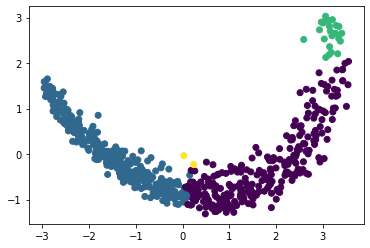

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x, y = pca.fit_transform(cons_res.B).T
plt.scatter(x, y, c=S_euclidean)

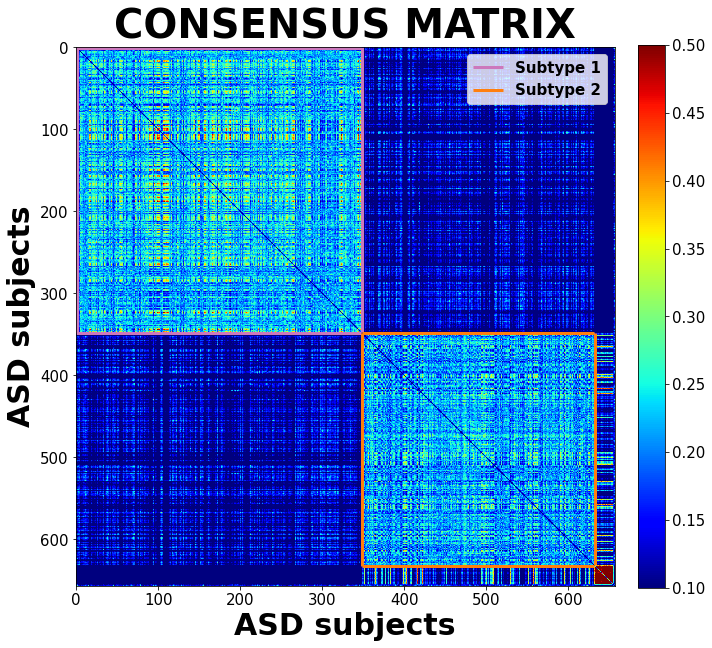

In [7]:
current_palette=sns.color_palette('colorblind')

clus_idxs = np.concatenate(subjects_clusters_euclidean['clus_idxs'])
cons_mat = C_euclidean

n_1, n_2, n_3, _ = np.unique(np.concatenate(subjects_clusters_euclidean['cluster_labels']), 
                             return_counts=True)[1]

fig, ax = plt.subplots(figsize=(10, 10))
im= ax.imshow(cons_mat[clus_idxs, :][:,clus_idxs], 
              cmap = plt.cm.jet, vmin=0.1, vmax=0.5)
ax.set_title("CONSENSUS MATRIX", {"fontsize":40, "fontweight":"bold"})
ax.set_xlabel("ASD subjects", {"fontsize": 30, "fontweight":"bold"})
ax.set_ylabel("ASD subjects", {"fontsize": 30, "fontweight":"bold"})
cbar=plt.colorbar(im, fraction=0.046, pad=0.04)

x0, xf = 0, n_1
y0, yf = 0, n_1

plt.vlines(x=x0 + 1, ymin =y0, ymax = yf , color=current_palette[4], linewidth=3)
plt.vlines(x=xf, ymin =y0, ymax = yf - 1, color=current_palette[4],  linewidth=3)

plt.hlines(y=y0 + 1, xmin =x0, xmax = xf-1, color=current_palette[4],  linewidth=3)
plt.hlines(y=yf, xmin =x0, xmax = xf-1, color=current_palette[4],  linewidth=3, label="Subtype 1")


x0 = xf
xf += n_2
y0 = yf
yf += n_2

plt.vlines(x=x0, ymin =y0, ymax = yf , color=sns.color_palette()[1],  linewidth=3)
plt.vlines(x=xf, ymin =y0, ymax = yf - 1, color=sns.color_palette()[1], linewidth=3)
plt.hlines(y=y0, xmin =x0, xmax = xf-1, color=sns.color_palette()[1], linewidth=3)
plt.hlines(y=yf, xmin =x0, xmax = xf-1, color=sns.color_palette()[1], linewidth=3,  label="Subtype 2")

x0 = xf
xf += n_3
y0 = yf
yf += n_3


plt.legend(ncol=1, prop={'size':15, 'weight':'bold'})
ax.tick_params(labelsize=15)
cbar.ax.tick_params(labelsize=15) 
plt.tight_layout()
plt.savefig(opj(plot_dir, "consensus_mat.png"), dpi=600)
plt.savefig(opj(plot_dir, "consensus_mat.svg"), dpi=600)

# Explore the ASD differencies

Add cluster ID column

In [8]:
demo_data['clus_id_euclidean'] = pd.NA

demo_data.loc[demo_data.SUB_ID.isin(tc_subjects), 'clus_id_euclidean'] = 0

for sub_clus, clus_label in zip(subjects_clusters_euclidean['clus_subj'], 
                                subjects_clusters_euclidean['cluster_labels']):
    demo_data.loc[demo_data.SUB_ID.isin(sub_clus), 'clus_id_euclidean'] = clus_label
    
demo_data.clus_id_euclidean.value_counts()

0          884
1          348
2          284
3           23
outlier      2
Name: clus_id_euclidean, dtype: int64

Subjects proportion of each subtype

In [9]:
print(f"Subtype 1: {np.round(100*sum(demo_data['clus_id_euclidean']==1)/sum(demo_data.DX_GROUP==1), 2)}%")
print(f"Subtype 2: {np.round(100*sum(demo_data['clus_id_euclidean']==2)/sum(demo_data.DX_GROUP==1), 2)}%")

Subtype 1: 52.97%
Subtype 2: 43.23%


Save demo data with subtypes ids for later use

In [10]:
demo_data.to_excel(opj(results_dir,'pheno_w_clusters_reg82_My21.xlsx'), index=False)

Test statistical differences between subtypes 1 and 2 for motion, age and sex. If denoising did well its jobs, no differences between subtypes in these variables should be found

In [11]:
print("FD_mean: ", f_oneway(*[demo_data.loc[demo_data.clus_id_euclidean == clus_id,"FD_mean"].dropna() for clus_id in [1,2]]))
print("DVARS: ", f_oneway(*[demo_data.loc[demo_data.clus_id_euclidean == clus_id,"DVARS_mean"].dropna() for clus_id in [1,2]]))
print("AGE: ", f_oneway(*[demo_data.loc[demo_data.clus_id_euclidean == clus_id,"AGE_AT_SCAN"].dropna() for clus_id in [1,2]]))
print("SEX: ", chi2_contingency(pd.crosstab(demo_data.clus_id_euclidean, demo_data.SEX).iloc[1:3,:])[:2])

FD_mean:  F_onewayResult(statistic=0.22143183166034153, pvalue=0.6381139636709464)
DVARS:  F_onewayResult(statistic=0.050885173169210964, pvalue=0.8216032593541207)
AGE:  F_onewayResult(statistic=0.3089882852631505, pvalue=0.5784990287069605)
SEX:  (0.352772929507863, 0.5525476236334708)


## Behaviour: FIQ, VIQ, PIQ, ADI and ADOS

Create ADI total as the sum of both social and verbal skills

In [12]:
demo_data['ADI_TOTAL'] = demo_data.loc[:,["ADI_R_SOCIAL_TOTAL_A", "ADI_R_VERBAL_TOTAL_BV"]].sum(axis=1, skipna=False)

In [13]:
# Functions to print confidence intervals
def percentile_ci(x, stat=np.mean, alpha=0.05, n_boot=1000, random_state=None):
    
    if (stat != np.mean) & (stat != np.median):
        raise ValueError("stat should be np.mean for mean, or np.median for median")
    
    rng = np.random.RandomState(seed=random_state)
    
    x = np.asarray(x)
    m = len(x)
    quantiles = [alpha/2, 1-alpha/2]

    bs_index = rng.randint(m, size=(n_boot, m))
    x_boot = x[bs_index]
    estimate = stat(x_boot, axis=1)

    ci = np.quantile(estimate, quantiles)
    return ci


def aux_function(x, stat=np.mean, alpha=0.05, n_boot=1000, random_state=None):
    # Aux function ust to be able to use above function with apply pandas
    x = np.asarray(x) # Convert to numpy array
    x = x[x==x] # drop NaNs
    ci = percentile_ci(x, stat=stat, alpha=alpha, n_boot=n_boot, random_state=random_state)
    return pd.Series(ci, index=['cilo', 'cihi'])

In [14]:
beh_scores= ["FIQ","VIQ", 
             "PIQ",
             "ADI_TOTAL" ,
             "ADOS_TOTAL" 
            ]

print("----------------")
print("RAW P-VALUES:")
print("----------------")
list_pv_beh = []
for column in beh_scores:
    f, p = f_oneway(*[demo_data.loc[demo_data.clus_id_euclidean==clus_id,column].dropna() for 
                     clus_id in [1,2]])
    print(" (Raw) ANOVA of %s across subtypes = %.5f" %(column, p))
    list_pv_beh.append(p)
    
from statsmodels.stats.multitest import multipletests
list_pv_beh_fdr = multipletests(list_pv_beh, method="fdr_bh")[1]
print("----------------")
print("FDR P-VALUES:")
print("----------------")
for column, pv in zip(beh_scores, list_pv_beh_fdr):
    print(" (FDR) ANOVA of %s across subtypes = %.2f" % (column, pv))

print("----------------") 
print("COUNTS PER SUBTYPE")
print("----------------")
mask = (demo_data.clus_id_euclidean==1) | (demo_data.clus_id_euclidean==2)
print(demo_data.loc[mask,:].groupby("clus_id_euclidean")[beh_scores].count())
print("----------------")
print("TABLE")
print("----------------")
table_paper_df = demo_data.loc[mask,["clus_id_euclidean"] + beh_scores].groupby("clus_id_euclidean").mean().T

table_paper_df.columns = ["Subtype 1", "Subtype 2"]
table_paper_df['p-value'] = list_pv_beh_fdr

table_paper_df = table_paper_df.round(2)

table_paper_df.index = beh_scores
print(table_paper_df)

print("----------------")
print("CONFIDENCE INTERVALS:")
print("----------------")
group_df = demo_data.loc[mask,["clus_id_euclidean"] + beh_scores].groupby("clus_id_euclidean")
for var_name in beh_scores:
    print(var_name)
    print("1: ", group_df[var_name].apply(aux_function, 
                                   stat=np.mean, 
                                   alpha=0.05, 
                                   n_boot=1000, random_state=1234).round(2)[1].to_numpy())
    print("2: ", group_df[var_name].apply(aux_function, 
                                   stat=np.mean, 
                                   alpha=0.05, 
                                   n_boot=1000, random_state=1234).round(2)[2].to_numpy())
    print("")

----------------
RAW P-VALUES:
----------------
 (Raw) ANOVA of FIQ across subtypes = 0.24565
 (Raw) ANOVA of VIQ across subtypes = 0.13374
 (Raw) ANOVA of PIQ across subtypes = 0.80444
 (Raw) ANOVA of ADI_TOTAL across subtypes = 0.21283
 (Raw) ANOVA of ADOS_TOTAL across subtypes = 0.03077
----------------
FDR P-VALUES:
----------------
 (FDR) ANOVA of FIQ across subtypes = 0.31
 (FDR) ANOVA of VIQ across subtypes = 0.31
 (FDR) ANOVA of PIQ across subtypes = 0.80
 (FDR) ANOVA of ADI_TOTAL across subtypes = 0.31
 (FDR) ANOVA of ADOS_TOTAL across subtypes = 0.15
----------------
COUNTS PER SUBTYPE
----------------
                   FIQ  VIQ  PIQ  ADI_TOTAL  ADOS_TOTAL
clus_id_euclidean                                      
1                  321  273  277        228         221
2                  266  241  245        190         179
----------------
TABLE
----------------
            Subtype 1  Subtype 2  p-value
FIQ            105.23     106.81     0.31
VIQ            104.43     106.78

## Morphology: thickness and volumes from Freesurfer

In [15]:
ctx_vols_lh_abide_1 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_I/aparc_volume_lh.txt"), sep="\t")
ctx_vols_lh_abide_1.insert(0, 'Code',  ctx_vols_lh_abide_1.iloc[:, 0])
ctx_vols_lh_abide_1 =ctx_vols_lh_abide_1.drop(labels="lh.aparc.volume", axis=1)

ctx_vols_rh_abide_1 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_I/aparc_volume_rh.txt"), sep="\t")
ctx_vols_rh_abide_1.insert(0, 'Code',  ctx_vols_rh_abide_1.iloc[:, 0])
ctx_vols_rh_abide_1 =ctx_vols_rh_abide_1.drop(labels="rh.aparc.volume", axis=1)

ctx_vols_abide_1 = pd.merge(ctx_vols_lh_abide_1, ctx_vols_rh_abide_1, on="Code")

aseg_vols_abide_1 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_I/aseg_stats.txt"), sep="\t")
aseg_vols_abide_1.insert(0, 'Code',  aseg_vols_abide_1.iloc[:, 0])
aseg_vols_abide_1=aseg_vols_abide_1.drop(labels="Measure:volume", axis=1)

all_vols_abide_1 =  pd.merge(ctx_vols_abide_1, aseg_vols_abide_1, on="Code")

ctx_vols_lh_abide_2 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_II/aparc_volume_lh.txt"), sep="\t")
ctx_vols_lh_abide_2.insert(0, 'Code',  ctx_vols_lh_abide_2.iloc[:, 0])
ctx_vols_lh_abide_2 =ctx_vols_lh_abide_2.drop(labels="lh.aparc.volume", axis=1)

ctx_vols_rh_abide_2 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_II/aparc_volume_rh.txt"), sep="\t")
ctx_vols_rh_abide_2.insert(0, 'Code',  ctx_vols_rh_abide_2.iloc[:, 0])
ctx_vols_rh_abide_2 =ctx_vols_rh_abide_2.drop(labels="rh.aparc.volume", axis=1)

ctx_vols_abide_2 = pd.merge(ctx_vols_lh_abide_2, ctx_vols_rh_abide_2, on="Code")

aseg_vols_abide_2 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_II/aseg_stats.txt"), sep="\t")
aseg_vols_abide_2.insert(0, 'Code',  aseg_vols_abide_2.iloc[:, 0])
aseg_vols_abide_2=aseg_vols_abide_2.drop(labels="Measure:volume", axis=1)

all_vols_abide_2 =  pd.merge(ctx_vols_abide_2, aseg_vols_abide_2, on="Code")

# Concatenate both studies
all_vols_abide = pd.concat([all_vols_abide_1, all_vols_abide_2])
all_vols_abide.head()

,Code,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
0,Caltech_0051456,1967.0,1690.0,6465.0,2894.0,2202.0,10507.0,10987.0,11615.0,3126.0,...,1.118733e+06,1.074674e+06,1073578.0,1832304.0,0.644484,0.937216,68.0,61.0,129.0,1.955051e+06
1,Caltech_0051457,3213.0,2437.0,9443.0,3199.0,1978.0,14935.0,15506.0,13276.0,3430.0,...,1.303300e+06,1.272875e+06,1271146.0,1974411.0,0.735642,0.982749,87.0,114.0,201.0,2.009069e+06
2,Caltech_0051458,3667.0,1464.0,6577.0,2236.0,2369.0,11564.0,14907.0,10195.0,2546.0,...,1.124768e+06,1.110744e+06,1109069.0,1687679.0,0.693319,0.906634,74.0,63.0,137.0,1.861477e+06
3,Caltech_0051459,3325.0,2042.0,9335.0,3102.0,2121.0,9838.0,13042.0,14264.0,2686.0,...,1.186453e+06,1.179557e+06,1177728.0,1746576.0,0.732057,0.957557,65.0,68.0,133.0,1.823992e+06
4,Caltech_0051460,2488.0,2073.0,7503.0,3621.0,2414.0,9055.0,10645.0,11210.0,2790.0,...,1.058756e+06,1.045414e+06,1044074.0,1551830.0,0.699034,0.909037,54.0,43.0,97.0,1.707115e+06


In [16]:
ctx_thick_lh_abide_1 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_I/aparc_thickness_lh.txt"), sep="\t")
ctx_thick_lh_abide_1.insert(0, 'Code',  ctx_thick_lh_abide_1.iloc[:, 0])
ctx_thick_lh_abide_1 = ctx_thick_lh_abide_1.drop(labels="lh.aparc.thickness", axis=1)

ctx_thick_rh_abide_1 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_I/aparc_thickness_rh.txt"), sep="\t")
ctx_thick_rh_abide_1.insert(0, 'Code',  ctx_thick_rh_abide_1.iloc[:, 0])
ctx_thick_rh_abide_1 =ctx_thick_rh_abide_1.drop(labels="rh.aparc.thickness", axis=1)

ctx_thick_abide_1 = pd.merge(ctx_thick_lh_abide_1, ctx_thick_rh_abide_1, on="Code")


ctx_thick_lh_abide_2 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_II/aparc_thickness_lh.txt"), sep="\t")
ctx_thick_lh_abide_2.insert(0, 'Code',  ctx_thick_lh_abide_2.iloc[:, 0])
ctx_thick_lh_abide_2 =ctx_thick_lh_abide_2.drop(labels="lh.aparc.thickness", axis=1)

ctx_thick_rh_abide_2 = pd.read_csv(opj(data_dir, "freeS/freesurfer_stats_II/aparc_thickness_rh.txt"), sep="\t")
ctx_thick_rh_abide_2.insert(0, 'Code',  ctx_thick_rh_abide_2.iloc[:, 0])
ctx_thick_rh_abide_2 =ctx_thick_rh_abide_2.drop(labels="rh.aparc.thickness", axis=1)

ctx_thick_abide_2 = pd.merge(ctx_thick_lh_abide_2, ctx_thick_rh_abide_2, on="Code")

all_thick_abide = pd.concat([ctx_thick_abide_1, ctx_thick_abide_2])
all_thick_abide.head()

,Code,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Caltech_0051456,2.174,2.781,2.455,1.875,3.111,2.681,2.300,2.793,2.134,...,2.422,2.838,2.150,2.735,2.503,2.546,3.563,2.420,3.019,2.45384
1,Caltech_0051457,2.486,2.779,2.551,2.013,3.159,2.760,2.430,2.742,2.664,...,2.436,2.719,1.962,2.884,2.429,2.454,4.107,2.517,3.156,2.47580
2,Caltech_0051458,2.684,2.194,2.587,1.873,3.732,2.787,2.544,2.804,2.279,...,2.573,2.775,2.232,3.184,2.692,2.910,4.024,2.407,3.044,2.55634
3,Caltech_0051459,2.673,2.220,2.905,1.814,3.217,2.711,2.688,2.856,2.181,...,2.797,3.049,2.514,3.187,2.826,3.105,4.204,2.371,3.281,2.71319
4,Caltech_0051460,2.488,2.446,2.590,1.904,3.419,2.645,2.304,2.787,2.238,...,2.485,2.806,2.034,2.755,2.604,2.993,4.029,2.525,2.943,2.45241


Add morphological data to demographics

In [17]:
demo_w_morpho_df = pd.merge(pd.merge(demo_data, all_vols_abide, on="Code"), all_thick_abide, on="Code")

In [18]:
covariates = ["Age", "Sex", "EstimatedTotalIntraCranialVol"]

sub_parcels = ["Left-Thalamus-Proper", "Left-Caudate", "Left-Putamen", "Left-Pallidum", 
               "Left-Hippocampus", "Left-Amygdala", "Left-Accumbens-area",
               "Right-Thalamus-Proper", "Right-Caudate", "Right-Putamen", "Right-Pallidum", 
               "Right-Hippocampus", "Right-Amygdala", "Right-Accumbens-area"]

new_sub_parcels = ["Left_Thalamus_Proper", "Left_Caudate", "Left_Putamen", "Left_Pallidum", 
               "Left_Hippocampus", "Left_Amygdala", "Left_Accumbens_area",
               "Right_Thalamus_Proper", "Right_Caudate", "Right_Putamen", "Right_Pallidum", 
               "Right_Hippocampus", "Right_Amygdala", "Right_Accumbens_area"]

demo_w_morpho_df.loc[:, new_sub_parcels]  = demo_w_morpho_df.loc[:, sub_parcels].rename(columns= lambda x: x.replace("-","_"))

Test differences betwen subtypes for each brain property using a Linear Mixed model and controlling for Sex, Age and Intracraneal Volume. We used a Linear Mixed model to take into account site effects

In [19]:
cond_12 = (demo_w_morpho_df.clus_id_euclidean==1) | (demo_w_morpho_df.clus_id_euclidean==2)

In [20]:
vols_vars = ctx_vols_abide_1.columns[1:].to_list()+ new_sub_parcels

pv_vols=[]
for parcel in vols_vars:
    lm_fit = smf.mixedlm(f"{parcel} ~ C(clus_id_euclidean) + C(SEX) + AGE_AT_SCAN + EstimatedTotalIntraCranialVol",
                     groups="SITE_ID_MERGED", data=demo_w_morpho_df[cond_12]).fit()
    
    pv = lm_fit.f_test(np.identity(len(lm_fit.params))[1:2]).pvalue
    pv = np.array([pv])[0]
    
    pv_vols.append(pv)

/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [21]:
is_sig = multipletests(pv_vols, method="fdr_bh")[0]
print(f"number of volumes significanly different between subject after FDR = {sum(is_sig)}")

number of volumes significanly different between subject after FDR = 0


In [22]:
thick_vars = all_thick_abide.columns[1:].to_list()

pv_thick=[]
for parcel in thick_vars:
    lm_fit = smf.mixedlm(f"{parcel} ~ C(clus_id_euclidean) + C(SEX) + AGE_AT_SCAN + EstimatedTotalIntraCranialVol",
                     groups="SITE_ID_MERGED", data=demo_w_morpho_df[cond_12]).fit()
    
    pv = lm_fit.f_test(np.identity(len(lm_fit.params))[1:2]).pvalue
    pv = np.array([pv])[0]
    
    pv_thick.append(pv)

/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be o

In [23]:
is_sig = multipletests(pv_thick, method="fdr_bh")[0]
print(f"number of thicknesses significanly differente between subject after FDR = {sum(is_sig)}")

number of thicknesses significanly differente between subject after FDR = 0
